In [ ]:
pip install pytrends

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from pytrends.request import TrendReq
from pytrends import dailydata
from datetime import datetime, timedelta
from collections import OrderedDict
from calendar import monthrange

In [1]:
import pandas as pd 

In [2]:
df_mob=pd.read_csv('../scraped_data_download/canada_mobility.csv')
df_count=pd.read_csv('../scraped_data_download/dailytotals.csv')
df_travel=pd.read_csv('../scraped_data_download/travel.csv')
df_apple=pd.read_csv('../scraped_data_download/applemobilitytrends-2021-04-16.csv')

C:\Users\Shobhit\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#Cleaning and appending to travel dataframe
newcol=['canada','quebec','ontario','alberta','british columbia','canada-us','quebec-us','ontario-us','alberta-us','british columbia-us']
dic=dict.fromkeys(df_travel.columns[1:11])
i=0
for j in dic.keys():
  dic[j]=newcol[i]
  i=i+1
df_travel.rename(columns=dic,inplace=True)
for i in df_travel.columns[1:11]:
  df_travel[i]=df_travel[i].str.replace(',','')
  df_travel[i]=df_travel[i].astype(int)
df_travel.drop(columns=df_travel.columns[0],inplace=True)
a=[];b=[]
for c in newcol:
  a.append(int(df_travel[c][10:].mean()))
df_travel.loc[len(df_travel)]=a
i=0
for c in newcol: 
  b.append(int(df_travel[c][11:].mean()))
df_travel.loc[len(df_travel)]=b

In [ ]:
#Cleaning count dataframe
df_count['Province']=df_count['Province'].str.lower()
df_count['SummaryDate'] = df_count['SummaryDate'].str.replace('/','-')
df_count['SummaryDate'] = df_count['SummaryDate'].str.replace('12:00:00+00','')
df_count['SummaryDate']=pd.to_datetime(df_count['SummaryDate']).dt.date
df_count['Province']=df_count['Province'].replace(['nl','bc','repatriated cdn','nwt','pei'],['newfoundland and labrador','british columbia','repatriated','northwest territories','prince edward island'])

In [ ]:
#Cleaning mobility dataframe
df_mob.columns
dic=dict.fromkeys(df_mob.columns[9:15])
newcol=['recreation','essentials','parks','station_transit','workplace','resedential']
i=0
for j in dic.keys():
  dic[j]=newcol[i]
  i=i+1
df_mob.rename(columns=dic,inplace=True)
df_mob['sub_region_1']=df_mob['sub_region_1'].str.lower()
df_mob['date']=pd.to_datetime(df_mob['date']).dt.date

In [ ]:
#Cleaning apple mobility dataframe
df_apple.drop(df_apple.loc[df_apple['country']!='Canada'].index, inplace=True)
for i in df_apple.index:
  if df_apple.loc[i,'region']=='Alberta':
    df_apple.loc[i,'sub-region']='Alberta'
  elif df_apple.loc[i,'region']=='British Columbia':
    df_apple.loc[i,'sub-region']='British Columbia'
  elif df_apple.loc[i,'region']=='Ontaio':
    df_apple.loc[i,'sub-region']='Ontario'
  elif df_apple.loc[i,'region']=='Quebec':
    df_apple.loc[i,'sub-region']='Quebec'
df_apple.drop(df_apple.loc[~df_apple['sub-region'].isin(['Alberta','Ontario','Quebec','British Columbia'])].index, inplace=True)
df_apple.drop(columns=['geo_type','region','alternative_name','country'],inplace=True)
a=df_apple.groupby(['sub-region','transportation_type'])
for i in df_apple['sub-region'].unique():
  for j in df_apple['transportation_type'].unique():
    di=OrderedDict()
    di['transportation_type']=j
    di['sub-region']=i
    for k in df_apple.columns[2:]:
      di[k]=a.get_group((i,j))[k].mean()
    df_apple=df_apple.append(di,ignore_index=True)
df_apple=df_apple.drop(df_apple.index[0:27])
df_apple['sub-region']=df_apple['sub-region'].str.lower()
for t in df_apple.index:
  for i,j in enumerate(df_apple.columns[2:]):
    if pd.isna(df_apple.loc[t,j]):
      df_apple.loc[t,j]=(df_apple.loc[t,df_apple.columns[i]] + df_apple.loc[t,df_apple.columns[i]])/2

In [ ]:
#Generating total sum plots for each territory
prov=df_count.groupby('Province')
data_total={}
data_deaths={}
loc={}
deathperc={}
for i,p in enumerate(prov.indices):
  data_total[p]=prov.get_group(p)['DailyTotals'].sum()
  data_deaths[p]=prov.get_group(p)['DailyDeaths'].sum()
  loc[i]=p
y=np.arange(len(loc))

for k in data_total.keys():
  deathperc[k]=round(data_deaths[k]/data_total[k],4)

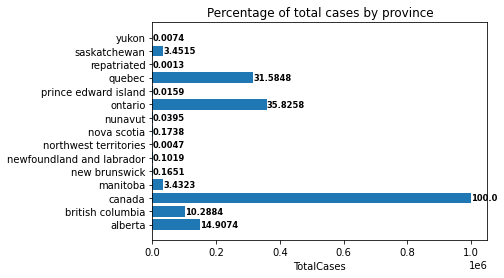

Percentage of cases from top 4 provinces: 92.6064
Percentage of cases from top 6 provinces: 99.4902


In [ ]:
#Case distribution by provinces
plt.barh(y,data_total.values())
plt.yticks(y,loc.values())
plt.xlabel('TotalCases')
for i, v in enumerate(data_total.values()):
    plt.text(v+3, i-0.2, str(round(v*100/data_total['canada'],4)), color='black', fontweight='bold',fontsize='small')
plt.title('Percentage of total cases by province')
plt.show()
top4=round((data_total['quebec']+data_total['ontario']+data_total['british columbia']+data_total['alberta'])*100/data_total['canada'],4)
top6=round((data_total['quebec']+data_total['ontario']+data_total['british columbia']+data_total['alberta']+data_total['saskatchewan']+data_total['manitoba'])*100/data_total['canada'],4)
print('Percentage of cases from top 4 provinces:',top4)
print('Percentage of cases from top 6 provinces:',top6)

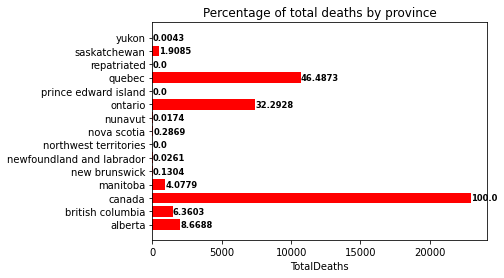

Percentage of deaths from top 4 provinces: 93.8092


In [ ]:
plt.barh(y,data_deaths.values(),color='red')
plt.yticks(y,loc.values())
plt.xlabel('TotalDeaths')
for i, v in enumerate(data_deaths.values()):
    plt.text(v+3, i-0.2, str(round(v*100/data_deaths['canada'],4)), color='black', fontweight='bold',fontsize='small')
plt.title('Percentage of total deaths by province')
plt.show()
top4=round((data_deaths['quebec']+data_deaths['ontario']+data_deaths['british columbia']+data_deaths['alberta'])*100/data_deaths['canada'],4)
print('Percentage of deaths from top 4 provinces:',top4)

In [ ]:
def top4_clean(df):
  df['SummaryDate'] = df['SummaryDate'].str.replace('/','-')
  df['SummaryDate'] = df['SummaryDate'].str.replace('12:00:00+00','')
  df['SummaryDate']=pd.to_datetime(df['SummaryDate']).dt.date
  df.drop(columns=['Province','Abbreviation','OBJECTID'],inplace=True)
  df.set_index('SummaryDate',inplace=True)
  return df

In [ ]:
def logdiff(df,date,nmonth):
  df=top4_clean(df)
  totcases=[];totdeaths=[];dates=[];daily=[]
  start=date
  if date.year==2020:
    for d in df.index.unique():
      if d.month>nmonth and d.year==2020:
        break
      elif d>=start and d.year==2020:
        totcases.append(df.loc[d,'TotalCases'])
        totdeaths.append(df.loc[d,'TotalDeaths'])
        daily.append(df.loc[d,'DailyTotals'])
        dates.append(d)
  elif date.year==2021:
    for d in df.index.unique()[335:]:
        totcases.append(df.loc[d,'TotalCases'])
        totdeaths.append(df.loc[d,'TotalDeaths'])
        daily.append(df.loc[d,'DailyTotals'])
        dates.append(d)
  df=pd.DataFrame(list(zip(np.hstack(totcases),np.hstack(totdeaths),np.hstack(dates),np.hstack(daily))),columns=['totcases','totdeaths','date','daily'])
  for i in range(len(df)):
    df.loc[i,'logtot']=np.log(df.loc[i,'totcases'])
    df.loc[i,'logdet']=np.log(df.loc[i,'totdeaths'])
  for i in range(1,len(df)):
    df.loc[i,'logdiff']=df.loc[i,'logtot']-df.loc[i-1,'logtot']
    df.loc[i,'logddiff_det']=df.loc[i,'logdet']-df.loc[i-1,'logdet']
  for i in range(1,len(df)):
    df.loc[i,'diff']=df.loc[i,'daily']-df.loc[i-1,'daily']
  df.set_index('date',inplace=True)
  return df

In [ ]:
def corr_mob(df,date,nmonth,province):
  prov_mob=df_mob.groupby('sub_region_1')
  prov_mob_daily=df_mob.groupby(['sub_region_1','date'])
  apple_mob=df_apple.groupby(['sub-region','transportation_type'])
  us=province+'-us'
  top1=np.zeros((99,3));top2=np.zeros((99,3))
  j=0
  p1=df.isnull().sum()['logdiff']
  p2=df_ab.isnull().sum()['logddiff_det']
  #p2=df.isnull().sum()['diff']
  if date.year==2020:
    for i in range(6,15):
      trans=[];walk=[];drive=[];rec=[];ess=[];par=[];st=[];wp=[];res=[];t1=[];t2=[]
      for d in df.index.unique():
        off=d-timedelta(days=i)
        trans.append(apple_mob.get_group((province,'transit'))[str(off)])
        walk.append(apple_mob.get_group((province,'walking'))[str(off)])
        drive.append(apple_mob.get_group((province,'driving'))[str(off)])
        rec.append(prov_mob_daily.get_group((province,off))['recreation'].mean())
        ess.append(prov_mob_daily.get_group((province,off))['essentials'].mean())
        par.append(prov_mob_daily.get_group((province,off))['parks'].mean())
        st.append(prov_mob_daily.get_group((province,off))['station_transit'].mean())
        wp.append(prov_mob_daily.get_group((province,off))['workplace'].mean())
        res.append(prov_mob_daily.get_group((province,off))['resedential'].mean())
        days=monthrange(2020,off.month)[1]
        t1u=df_travel.loc[off.month-1,province]/days
        t2u=df_travel.loc[off.month-1,us]/days
        t1s=t1u*10/100
        t2s=t2u*10/100
        t1.append(np.random.normal(t1u,t1s))
        t2.append(np.random.normal(t2u,t2s))
      test=[trans,walk,drive,rec,ess,par,st,wp,res,t1,t2]
      for n,col in enumerate(test):
        top1[j][2]=np.corrcoef(df['logdiff'][p1:],np.hstack(col)[p1:])[1][0]
        top1[j][1]=n
        top1[j][0]=i
        top2[j][2]=np.corrcoef(df['diff'][p2:],np.hstack(col)[p2:])[1][0] #O deaths in first 10 columns
        top2[j][1]=n
        top2[j][0]=i
        j=j+1
  elif date.year==2021:
    top1=np.zeros((45,3));top2=np.zeros((45,3))
    for i in range(6,15):
      trans=[];walk=[];drive=[];t1=[];t2=[]
      for d in df.index.unique():
        off=d-timedelta(days=i)
        trans.append(apple_mob.get_group((province,'transit'))[str(off)])
        walk.append(apple_mob.get_group((province,'walking'))[str(off)])
        drive.append(apple_mob.get_group((province,'driving'))[str(off)])
        if off.year==2020:
          mon=12
          days=monthrange(2020,mon)[1]
          t1u=df_travel.loc[mon-1,province]/days
          t2u=df_travel.loc[mon-1,us]/days
        else:
           mon=off.month 
           days=monthrange(2020,mon)[1]
           t1u=df_travel.loc[mon+11,province]/days
           t2u=df_travel.loc[mon+11,us]/days
        t1s=t1u*10/100
        t2s=t2u*10/100
        t1.append(np.random.normal(t1u,t1s))
        t2.append(np.random.normal(t2u,t2s))
      test=[trans,walk,drive,t1,t2]
      for n,col in enumerate(test):
        top1[j][2]=np.corrcoef(df['logdiff'][p1:],np.hstack(col)[p1:])[1][0]
        top1[j][1]=n
        top1[j][0]=i
        top2[j][2]=np.corrcoef(df['logddiff_det'][p2:],np.hstack(col)[p2:])[1][0] #O deaths in first 10 columns
        top2[j][1]=n
        top2[j][0]=i
        j=j+1
  return top1,top2

In [ ]:
def corr_cols(df,df_dat,date,nmonth):
  j=0
  top1=np.zeros((63,3));top2=np.zeros((63,3))
  p1=df_ab.isnull().sum()['logdiff']+1
  p2=df_ab.isnull().sum()['logddiff_det']+1
  for i in range(6,15):
    if date.year==2021:
      rec=[];hosp=[];icu=[];tes=[];active=[];dvacc=[];totvacc=[]
      for d in df.index.unique():
        off=d-timedelta(days=i)
        hosp.append(df_dat.loc[off,'TotalHospitalized'])
        tes.append(df_dat.loc[off,'DailyTested'])
        icu.append(df_dat.loc[off,'TotalICU'])
        rec.append(df_dat.loc[off,'TotalRecovered'])
        active.append(df_dat.loc[off,'TotalActive'])
        dvacc.append(df_dat.loc[off,'DailyVaccinated'])
        totvacc.append(df_dat.loc[off,'TotalVaccinated'])
      test=[rec,hosp,icu,tes,active,dvacc,totvacc]
      for n,col in enumerate(test):
        top1[j][2]=np.corrcoef(df['logdiff'][p1:],np.hstack(col)[p1:])[1][0]
        top1[j][1]=n
        top1[j][0]=i
        top2[j][2]=np.corrcoef(df['logddiff_det'][p2:],np.hstack(col)[p2:])[1][0] #O deaths in first 10 columns
        top2[j][1]=n
        top2[j][0]=i
        j=j+1
    elif date.year==2020:
      rec=[];hosp=[];icu=[];tes=[];active=[]
      for d in df.index.unique():
        off=d-timedelta(days=i)
        hosp.append(df_dat.loc[off,'TotalHospitalized'])
        tes.append(df_dat.loc[off,'DailyTested'])
        icu.append(df_dat.loc[off,'TotalICU'])
        rec.append(df_dat.loc[off,'TotalRecovered'])
        active.append(df_dat.loc[off,'TotalActive'])
      test=[rec,hosp,icu,tes,active]
      for n,col in enumerate(test):
        top1[j][2]=np.corrcoef(df['logdiff'][p1:],np.hstack(col)[p1:])[1][0]
        top1[j][1]=n
        top1[j][0]=i
        top2[j][2]=np.corrcoef(df['logddiff_det'][p2:],np.hstack(col)[p2:])[1][0] #O deaths in first 10 columns
        top2[j][1]=n
        top2[j][0]=i
        j=j+1
  return top1,top2

In [ ]:
def corr_words(df,date,nmonth,abv,words=[]):
  p1=df.isnull().sum()['logdiff']+1
  if date.year==2020:
    mb1_trend=dailydata.get_daily_data(words[0],2020,date.month-1, 2020, nmonth, geo = abv)
    mb2_trend=dailydata.get_daily_data(words[1],2020,date.month-1, 2020, nmonth, geo = abv)
    mb3_trend=dailydata.get_daily_data(words[2],2020,date.month-1,2020,nmonth,geo=abv)
  elif date.year==2021:
    mb1_trend=dailydata.get_daily_data(words[0],2020,12, 2021, nmonth, geo = abv)
    mb2_trend=dailydata.get_daily_data(words[1],2020,12, 2021, nmonth, geo = abv)
    mb3_trend=dailydata.get_daily_data(words[2],2020,12,2021,nmonth,geo=abv)
  s1=words[0]+'_unscaled'
  s2=words[1]+'_unscaled'
  s3=words[2]+'_unscaled'
  top=np.zeros((42,2))
  j=0
  for i in range(1,15):
    w1=[];w2=[];w3=[]
    for d in df.index.unique():
      off=d-timedelta(days=i)
      w1.append(mb1_trend.loc[str(off),s1])
      w2.append(mb2_trend.loc[str(off),s2])
      w3.append(mb3_trend.loc[str(off),s3])
    for k,c in enumerate([w1,w2,w3]):
      top[j][1]=np.corrcoef(df['logdiff'][p1:],np.hstack(c[p1:]))[1][0]
      top[j][0]=i
      j=j+1
  return top

In [ ]:
def create_dataset(df,df_data,province,date,nmonth,abv,word,offset=[]):
  prov_mob=df_mob.groupby('sub_region_1')
  prov_mob_daily=df_mob.groupby(['sub_region_1','date'])
  apple_mob=df_apple.groupby(['sub-region','transportation_type'])
  us=province+'-us'
  start=date 
  li1=['transit','walking','driving']
  li2=['recreation','essentials','parks','station_transit','workplace','resedential']
  li3=['TotalHospitalized','DailyTested','TotalICU','TotalRecovered','TotalActive']
  t1=[];t2=[]
  for c in li1:
    el=[]
    for d in df.index.unique():
      off=d-timedelta(days=offset[0])
      el.append(apple_mob.get_group((province,c))[str(off)])
    #print(np.hstack(el))
    df[c]=np.hstack(el)
  if date.year==2020:
    for c in li2:
      el=[]
      for d in df.index.unique():
        off=d-timedelta(days=offset[0])
        el.append(prov_mob_daily.get_group((province,off))[c].mean())
      df[c]=np.hstack(el)
  for c in li3:
    el=[]
    for d in df.index.unique():
      off=d-timedelta(days=offset[1])
      el.append(df_data.loc[off,c])
    df[c]=np.hstack(el)
  if date.year==2020:
    for d in df.index.unique():
      off=d-timedelta(days=offset[2])
      days=monthrange(2020,off.month)[1]
      t1u=df_travel.loc[off.month-1,province]/days
      t2u=df_travel.loc[off.month-1,us]/days
      t1s=t1u*10/100
      t2s=t2u*10/100
      t1.append(np.random.normal(t1u,t1s))
      t2.append(np.random.normal(t2u,t2s))
    df[province]=np.hstack(t1)
    df[us]=np.hstack(t2)
  if date.year==2021:
    for d in df.index.unique():
      off=d-timedelta(days=offset[2])
      if off.year==2020:
        mon=12
        days=monthrange(2020,mon)[1]
        t1u=df_travel.loc[mon-1,province]/days
        t2u=df_travel.loc[mon-1,us]/days
      else:
        mon=off.month 
        days=monthrange(2020,mon)[1]
        t1u=df_travel.loc[mon+11,province]/days
        t2u=df_travel.loc[mon+11,us]/days
      t1s=t1u*10/100
      t2s=t2u*10/100
      t1.append(np.random.normal(t1u,t1s))
      t2.append(np.random.normal(t2u,t2s))
    print(2)
    df[province]=np.hstack(t1)
    df[us]=np.hstack(t2)
  if date.year==2021:
    li4=['DailyVaccinated','TotalVaccinated']
    for d in df.index.unique():
      off1=d-timedelta(days=offset[1])
      for c in li4:
        df.loc[d,c]=df_data.loc[off1,c]
  if date.month==1:
    end1=12
    end2=2021
  else:
    end1=date.month-1
    end2=2020
  w1=[]
  mb1_trend=dailydata.get_daily_data(word, 2020,end1,end2,nmonth, geo = abv)
  s1=word+'_unscaled'
  for d in df.index.unique():
    off2=d-timedelta(days=offset[2])
    if mb1_trend.loc[str(off2),s1]==0:
      w1.append(0.0001)
    else:
      w1.append(mb1_trend.loc[str(off2),s1])   
  df[word]=np.hstack(w1)
  return df

In [3]:
df_ontario=pd.read_csv('../scraped_data_download/ontario_totals.csv')#start with 335 for Jan 2021
#df_quebec=pd.read_csv('../scraped_data_download/Quebec_totals.csv')
#df_alberta=pd.read_csv('../scraped_data_download/Alberta_totals.csv')
#df_british=pd.read_csv('../scraped_data_download/BritishColumbia_totals.csv')

In [ ]:
df_on=logdiff(df_ontario,datetime(2020,3,1).date(),12)
#df_on_vacc=logdiff(df_ontario_vacc,datetime(2021,1,1).date(),4)
#df_qb=logdiff(df_quebec,datetime(2020,3,1).date(),12)
#df_qb_vacc=logdiff(df_quebec,datetime(2021,1,1).date(),4)
#df_ab=logdiff(df_alberta,datetime(2020,3,1).date(),12)
#df_ab_vacc=logdiff(df_alberta,datetime(2021,1,1).date(),4)
#df_bc=logdiff(df_british,datetime(2020,3,1).date(),12)
#df_bc_vacc=logdiff(df_british,datetime(2021,1,1).date(),4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


Text(0.5, 1.0, 'daily totals')

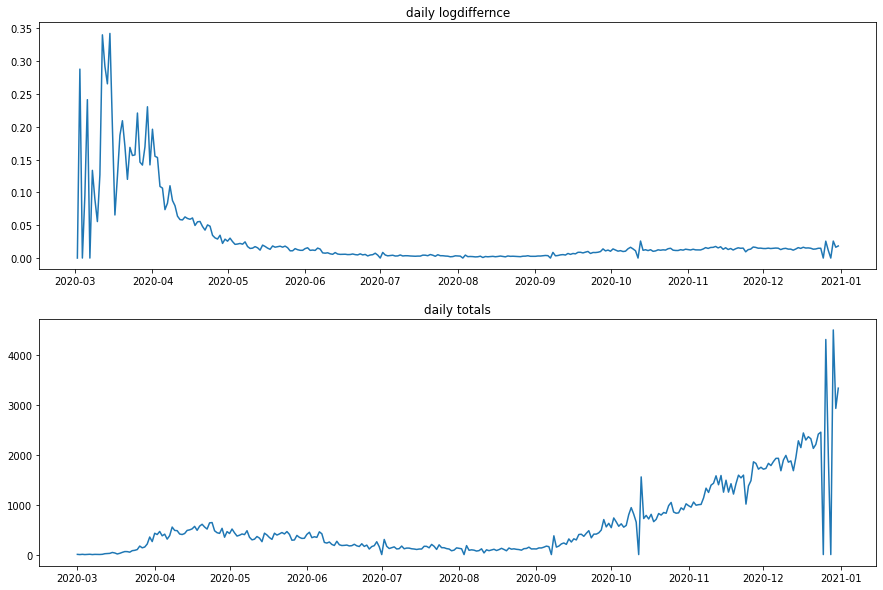

In [ ]:
f,ax=plt.subplots(2,1,figsize=(15,10))
ax[0].plot(df_on['logdiff'])
ax[0].set_title('daily logdiffernce')
ax[1].plot(df_on['daily'])
ax[1].set_title('daily totals')

In [ ]:
a,b=corr_mob(df_on,datetime(2020,3,1).date(),12,'ontario') #9 days,14 days; 10days,12 days
#a,b=corr_mob(df_on_vacc,datetime(2021,3,1).date(),4,'ontario') #8 days; 12days
#a,b=corr_mob(df_qb,datetime(2020,3,1).date(),12,'quebec')#9 days
#a,b=corr_mob(df_qb_vacc,datetime(2021,1,1).date(),4,'quebec')#9 days
#a,b=corr_mob(df_ab,datetime(2020,3,1).date(),12,'alberta')#9 days
#a,b=corr_mob(df_ab_vacc,datetime(2021,1,1).date(),4,'alberta')#13 days
#a,b=corr_mob(df_bc,datetime(2020,3,1).date(),12,'british columbia')#7days
#a,b=corr_mob(df_bc_vacc,datetime(2021,1,1).date(),4,'british columbia')#8days

In [ ]:
f,ax=plt.subplots(2,1,figsize=(20,10))
ax[0].plot(a.T[0],a.T[2])
ax[0].set_xlabel('Days offset')
ax[0].set_ylabel('Correlation')
ax[1].plot(b.T[0],b.T[2])
ax[1].set_xlabel('Days offset')
ax[1].set_ylabel('Correlation')

In [ ]:
#c,d=corr_cols(df_on,df_ontario,datetime(2020,3,1).date(),12) #10days,12 days,14 days; 10 days,11 days
#c,d=corr_cols(df_on_vacc,df_ontario_vacc,datetime(2021,1,1).date(),4) #6days; 10 days,11 days
#c,d=corr_cols(df_qb,df_quebec,datetime(2020,3,1).date(),12) #6days
#c,d=corr_cols(df_qb_vacc,df_quebec,datetime(2021,1,1).date(),4) #6days
#c,d=corr_cols(df_ab,df_alberta,datetime(2020,3,1).date(),12)#12 days
#c,d=corr_cols(df_ab_vacc,df_alberta,datetime(2021,1,1).date(),4)#6days
#c,d=corr_cols(df_bc,df_british,datetime(2020,3,1).date(),12)#9days
c,d=corr_cols(df_bc_vacc,df_british,datetime(2021,1,1).date(),4)#7days

In [ ]:
f,ax=plt.subplots(2,1,figsize=(20,10))
ax[0].plot(c.T[0],c.T[2])
ax[0].set_xlabel('Days offset')
ax[0].set_ylabel('Correlation')
ax[1].plot(d.T[0],d.T[2])
ax[1].set_xlabel('Days offset')
ax[1].set_ylabel('Correlation')

In [ ]:
#e=corr_words(df_on,datetime(2020,3,1).date(),12,'CA-ON',['Coronavirus','Lockdown','Coronavirus Ontario'])# Coronavirus 10,11 days
#e=corr_words(df_on_vacc,datetime(2021,1,1).date(),4,'CA-ON',['Coronavirus','Vaccine','Ontario Vaccine']) #Ontario Vaccine 3 days
#e=corr_words(df_qb,datetime(2020,3,1).date(),12,'CA-QC',['Coronavirus','Lockdown','Coronavirus Quebec']) #Coronavirus 4 days
#e=corr_words(df_qb_vacc,datetime(2021,1,1).date(),4,'CA-QC',['Coronavirus','Vaccine','Quebec Vaccine'])# Quebec Vaccine 3 days
#e=corr_words(df_ab,datetime(2020,3,1).date(),12,'CA-AB',['Coronavirus','Lockdown','Coronavirus Alberta'])#Coronavirus 5 days
#e=corr_words(df_ab_vacc,datetime(2021,1,1).date(),4,'CA-AB',['Coronavirus','Vaccine','Alberta Vaccine'])#Alberta Vaccine 7 days
#e=corr_words(df_bc,datetime(2020,3,1).date(),12,'CA-BC',['Coronavirus','Lockdown','Coronavirus BC'])#Coronavirus 14days
e=corr_words(df_bc_vacc,datetime(2021,1,1).date(),4,'CA-BC',['Coronavirus','Vaccine','BC Vaccine'])#Coronavirus 6days

Coronavirus:2020-12-01 2020-12-31
Coronavirus:2021-01-01 2021-01-31
Coronavirus:2021-02-01 2021-02-28
Coronavirus:2021-03-01 2021-03-31
Coronavirus:2021-04-01 2021-04-30
Vaccine:2020-12-01 2020-12-31
Vaccine:2021-01-01 2021-01-31
Vaccine:2021-02-01 2021-02-28
Vaccine:2021-03-01 2021-03-31
Vaccine:2021-04-01 2021-04-30
BC Vaccine:2020-12-01 2020-12-31
BC Vaccine:2021-01-01 2021-01-31
BC Vaccine:2021-02-01 2021-02-28
BC Vaccine:2021-03-01 2021-03-31
BC Vaccine:2021-04-01 2021-04-30


In [ ]:
plt.plot(e.T[0],e.T[1])

In [ ]:
#ontario=create_dataset(df_on,df_ontario,'ontario',datetime(2020,3,1).date(),12,'CA-ON','Coronavirus',[9,10,10])
#ontario_vacc=create_dataset(df_on_vacc,df_ontario_vacc,'ontario',datetime(2021,1,1).date(),4,'CA-ON','Ontario Vaccine',[8,6,3])
#quebec=create_dataset(df_qb,df_quebec,'quebec',datetime(2020,3,1).date(),12,'CA-QC','Coronavirus',[9,6,4])
#quebec_vacc=create_dataset(df_qb_vacc,df_quebec,'quebec',datetime(2021,1,1).date(),4,'CA-QC','Quebec Vaccine',[9,6,3])
#alberta=create_dataset(df_ab,df_alberta,'alberta',datetime(2020,3,1).date(),12,'CA-AB','Coronavirus',[9,12,5])
#alberta_vacc=create_dataset(df_ab_vacc,df_alberta,'alberta',datetime(2021,1,1).date(),4,'CA-AB','Alberta Vaccine',[13,6,7])
#bc=create_dataset(df_bc,df_british,'british columbia',datetime(2020,3,1).date(),12,'CA-BC','Coronavirus',[7,9,14])
bc_vacc=create_dataset(df_bc_vacc,df_british,'british columbia',datetime(2021,1,1).date(),4,'CA-BC','Coronavirus',[8,7,6])

2
Coronavirus:2020-12-01 2020-12-31
Coronavirus:2021-01-01 2021-01-31
Coronavirus:2021-02-01 2021-02-28
Coronavirus:2021-03-01 2021-03-31
Coronavirus:2021-04-01 2021-04-30


In [ ]:
#ontario.to_csv('/content/drive/MyDrive/ML project/data files/ontario_data.csv')
#ontario_vacc.to_csv('/content/drive/MyDrive/ML project/data files/ontario_vacc.csv')
#quebec.to_csv('/content/drive/MyDrive/ML project/data files/quebec_data.csv')
#quebec_vacc.to_csv('/content/drive/MyDrive/ML project/data files/quebec_vacc.csv')
#alberta.to_csv('/content/drive/MyDrive/ML project/data files/alberta_data.csv')
#alberta_vacc.to_csv('/content/drive/MyDrive/ML project/data files/alberta_vacc.csv')
#bc.to_csv('/content/drive/MyDrive/ML project/data files/britishcolumbia_data.csv')
bc_vacc.to_csv('/content/drive/MyDrive/ML project/data files/britishcolumbia_vacc.csv')